In [4]:
import pandas as pd
import numpy as np

In [26]:
df = pd.read_csv('/Users/farizrzayev/Desktop/projects/bandora-task/Analyst_case_study.csv')
print(len(df))

df['loan_issued_at'] = df['loan_issued_at'].apply(pd.to_datetime)
df['report_date_local'] = df['report_date_local'].apply(pd.to_datetime)

df

555605


,borrower_id,loan_id,loan_issued_at,country,outstanding_balance,repaid_amount_day,loan_duration,days_past_due,report_date_local
0,129108573d472a140502088fa7bac107ba4f0065f36273...,ac32d5ae9235b45a06b862b626371efa4257a13ed172c8...,2025-06-12,Estonia,349.800,0.0,84,NaN,2025-07-08
1,9144bc499fbf3bfece3d8e7be17c251db7ad8dcb5f817d...,b30a628805f31fc543a28c4b27e2db9db964520ec324d5...,2025-04-19,Estonia,114.455,0.0,122,NaN,2025-07-08
2,9144bc499fbf3bfece3d8e7be17c251db7ad8dcb5f817d...,83b6f5511ba9235ad54c176d9768bcfc2125d435614581...,2025-04-23,Estonia,114.455,0.0,122,NaN,2025-07-08
3,9144bc499fbf3bfece3d8e7be17c251db7ad8dcb5f817d...,ae73d66a03b0426f28712322f7a86b0b3b82e6a6bd8070...,2025-05-31,Estonia,116.105,0.0,121,NaN,2025-07-08
4,9144bc499fbf3bfece3d8e7be17c251db7ad8dcb5f817d...,18d797cdcbf548155d0be637915466f0a31aca58891793...,2025-05-02,Estonia,114.455,0.0,122,NaN,2025-07-08
...,...,...,...,...,...,...,...,...,...
555600,588dab51d00f001c4efff7ad4be644636149b00ef6907d...,8cbd0878ed23f997b286aec657930d206544fd18017146...,2025-04-01,Estonia,4678.300,0.0,78,NaN,2025-04-01
555601,eb245a6c8f623631f0177808589449446e75c6f9de275d...,695a20647b40c3633ae3c086f44a54407203a09222ee3d...,2025-04-01,Estonia,467.500,0.0,36,NaN,2025-04-01
555602,f8bb80a4ce3c36548ac79184a6555b383455d236aed8db...,c7d467f10f9bbb5cab639aeea7fd893a09c645399259ef...,2025-04-01,Netherlands,1144.000,0.0,24,NaN,2025-04-01
555603,06f50ddb8dfb495e77c7dc6a1409f4d9f9c7502f59a0ae...,afb0e7f81368d97ce2d4cb4ba462f8bbc59347095c8b25...,2025-04-01,Netherlands,2288.000,0.0,60,NaN,2025-04-01


## A/B Split 
### Startified Method is preventing the bies bcs we are taking approx equal proportion of groups 

In [27]:
import numpy as np

# Work with the original dataset for splitting
# df = df.copy()

# Convert loan_issued_at to datetime
df['loan_issued_at'] = pd.to_datetime(df['loan_issued_at'])

# We want to split into two groups with balanced distributions:
# borrowers, loans, loans per country, outstanding debt.

# Step 1: Ensure unique loans are considered (loan_id as key)
unique_loans = df.groupby('loan_id').agg({
    'borrower_id': 'first',
    'country': 'first',
    'outstanding_balance': 'last'  # last balance recorded
}).reset_index()

np.random.seed(42)
shuffled_loans = unique_loans.sample(frac=1).reset_index(drop=True)

half = len(shuffled_loans) // 2
group_a_loans = shuffled_loans.iloc[:half]['loan_id']
group_b_loans = shuffled_loans.iloc[half:]['loan_id']

group_a_df = df[df['loan_id'].isin(group_a_loans)]
group_b_df = df[df['loan_id'].isin(group_b_loans)]


def summary_stats(data, name):
    return pd.DataFrame({
        'dataset': [name],
        'unique_borrowers': [data['borrower_id'].nunique()],
        'unique_loans': [data['loan_id'].nunique()],
        'loans_per_country': [data.groupby('country')['loan_id'].nunique().to_dict()],
        'total_outstanding_balance': [data['outstanding_balance'].sum(skipna=True)]
    })


summary_a = summary_stats(group_a_df, 'Group A')
summary_b = summary_stats(group_b_df, 'Group B')

summary = pd.concat([summary_a, summary_b], ignore_index=True)

summary


,dataset,unique_borrowers,unique_loans,loans_per_country,total_outstanding_balance
0,Group A,3848,5914,"{'Estonia': 2994, 'Netherlands': 2920}",5.716176e+08
1,Group B,3891,5915,"{'Estonia': 2931, 'Netherlands': 2984}",5.838976e+08


In [28]:
# Fill NaNs with the calculated difference
df['days_past_due'] = (df['report_date_local'] - df['loan_issued_at']).dt.days
df['days_past_due'] = df['days_past_due'].astype(int)
# df['is_late'] = np.where(df['days_past_due'].fillna(0) > 0, 1, 0)


In [10]:
df_sorted = df.sort_values(by=['borrower_id', 'report_date_local'])
df_sorted

# Probably there are bank holidays that caused different in number of days while calculating difference between loan issued_at and report date local 


,borrower_id,loan_id,loan_issued_at,country,outstanding_balance,repaid_amount_day,loan_duration,days_past_due,report_date_local
326201,00006f0463eb81e53ec28e0a1bd7e34b5a37b37a2eddd8...,b831f487e76f4acde072e1185ed88ec398a048907d9271...,2025-06-05,Netherlands,915.200,0.0,54,0,2025-06-05
318626,00006f0463eb81e53ec28e0a1bd7e34b5a37b37a2eddd8...,b831f487e76f4acde072e1185ed88ec398a048907d9271...,2025-06-05,Netherlands,915.200,0.0,54,1,2025-06-06
310928,00006f0463eb81e53ec28e0a1bd7e34b5a37b37a2eddd8...,b831f487e76f4acde072e1185ed88ec398a048907d9271...,2025-06-05,Netherlands,915.200,0.0,54,2,2025-06-07
303120,00006f0463eb81e53ec28e0a1bd7e34b5a37b37a2eddd8...,b831f487e76f4acde072e1185ed88ec398a048907d9271...,2025-06-05,Netherlands,915.200,0.0,54,3,2025-06-08
295213,00006f0463eb81e53ec28e0a1bd7e34b5a37b37a2eddd8...,b831f487e76f4acde072e1185ed88ec398a048907d9271...,2025-06-05,Netherlands,915.200,0.0,54,4,2025-06-09
...,...,...,...,...,...,...,...,...,...
50145,ffef781115755ff2b17c41e8840cbcd4b361389573ac40...,52560c7b9a2151a7272766683224bf46c6e03859b0d657...,2025-06-07,Netherlands,340.384,0.0,84,27,2025-07-04
39020,ffef781115755ff2b17c41e8840cbcd4b361389573ac40...,52560c7b9a2151a7272766683224bf46c6e03859b0d657...,2025-06-07,Netherlands,340.384,0.0,84,28,2025-07-05
27899,ffef781115755ff2b17c41e8840cbcd4b361389573ac40...,52560c7b9a2151a7272766683224bf46c6e03859b0d657...,2025-06-07,Netherlands,340.384,0.0,84,29,2025-07-06
16780,ffef781115755ff2b17c41e8840cbcd4b361389573ac40...,52560c7b9a2151a7272766683224bf46c6e03859b0d657...,2025-06-07,Netherlands,340.384,0.0,84,30,2025-07-07


In [30]:
df_sorted[df_sorted['loan_id'] == '871872d79b22a220b91662975210f84c2defcefea8410dd9f4498bc27e4a9e14']
# A) Interestingly, there are repayments made but outstanding balance did not change - 2025-06-07 (outstanding balanc - 232.210 and repayment is around 3.872, but next day outstanding balance is still same , why dd ot decrease in payment history ?
# B) Probably there are banking holidays that lead to a number of days difference between the first date of loan issue and report date local, and usually 6-7 payments date can be logged as Monday's run book date

,borrower_id,loan_id,loan_issued_at,country,outstanding_balance,repaid_amount_day,loan_duration,days_past_due,report_date_local
507770,5777df841907f705b2b0540c901f2cc06a4b6ac2881ec6...,871872d79b22a220b91662975210f84c2defcefea8410d...,2025-04-30,Estonia,233.200,0.0,78,0,2025-04-30
504581,5777df841907f705b2b0540c901f2cc06a4b6ac2881ec6...,871872d79b22a220b91662975210f84c2defcefea8410d...,2025-04-30,Estonia,233.200,0.0,78,1,2025-05-01
501258,5777df841907f705b2b0540c901f2cc06a4b6ac2881ec6...,871872d79b22a220b91662975210f84c2defcefea8410d...,2025-04-30,Estonia,233.200,0.0,78,2,2025-05-02
497863,5777df841907f705b2b0540c901f2cc06a4b6ac2881ec6...,871872d79b22a220b91662975210f84c2defcefea8410d...,2025-04-30,Estonia,233.200,0.0,78,3,2025-05-03
494384,5777df841907f705b2b0540c901f2cc06a4b6ac2881ec6...,871872d79b22a220b91662975210f84c2defcefea8410d...,2025-04-30,Estonia,233.200,0.0,78,4,2025-05-04
...,...,...,...,...,...,...,...,...,...
44473,5777df841907f705b2b0540c901f2cc06a4b6ac2881ec6...,871872d79b22a220b91662975210f84c2defcefea8410d...,2025-04-30,Estonia,239.712,0.0,78,65,2025-07-04
33350,5777df841907f705b2b0540c901f2cc06a4b6ac2881ec6...,871872d79b22a220b91662975210f84c2defcefea8410d...,2025-04-30,Estonia,239.712,0.0,78,66,2025-07-05
22230,5777df841907f705b2b0540c901f2cc06a4b6ac2881ec6...,871872d79b22a220b91662975210f84c2defcefea8410d...,2025-04-30,Estonia,239.712,0.0,78,67,2025-07-06
11112,5777df841907f705b2b0540c901f2cc06a4b6ac2881ec6...,871872d79b22a220b91662975210f84c2defcefea8410d...,2025-04-30,Estonia,239.712,0.0,78,68,2025-07-07


In [3]:
df.isnull().sum()

borrower_id                 0
loan_id                     0
loan_issued_at              0
country                     0
outstanding_balance         2
repaid_amount_day           0
loan_duration               0
days_past_due          541795
report_date_local           0
dtype: int64

In [ ]:
# loan_amount_est: outstanding balance at the earliest day with days_past_due == 0 (fallback to the first snapshot if none).
# outstanding_at_last_report: balance at the latest report_date_local.
# days_past_due_at_last and last_report_date: status/date at the latest snapshot.
# loan_duration: taken as the max value seen (should be constant per loan).
# max_days_past_due: the max DPD observed over the loan’s history.
# change_since_start and pct_change_since_start: evolution from start to last report.

In [12]:
# 1) Earliest snapshot with DPD==0 → starting amount (fallback: first available snapshot)
df_zero = (
    df[df['days_past_due'] == 0]
    .sort_values(['loan_id', 'report_date_local'])
)

if not df_zero.empty:
    idx_zero_earliest = df_zero.groupby('loan_id')['report_date_local'].idxmin()
    principal_at_start = df.loc[idx_zero_earliest, ['loan_id', 'outstanding_balance']].rename(
        columns={'outstanding_balance': 'principal_at_start'}
    )
else:
    principal_at_start = pd.DataFrame(columns=['loan_id', 'principal_at_start'])

first_snapshot = (
    df.sort_values(['loan_id', 'report_date_local'])
      .groupby('loan_id')
      .first()[['outstanding_balance']]
      .rename(columns={'outstanding_balance': 'first_snapshot_balance'})
      .reset_index()
)

loan_start_bal = first_snapshot.merge(principal_at_start, on='loan_id', how='left')
loan_start_bal['loan_amount_est'] = loan_start_bal['principal_at_start'].fillna(
    loan_start_bal['first_snapshot_balance']
)
loan_start_bal = loan_start_bal[['loan_id', 'loan_amount_est']]

# 2) Latest report per loan
df_sorted = df.sort_values(['loan_id', 'report_date_local'])
last_rows = df_sorted.groupby('loan_id').tail(1).copy()
last_metrics = last_rows[['loan_id', 'outstanding_balance', 'days_past_due', 'report_date_local']].rename(
    columns={
        'outstanding_balance': 'outstanding_at_last_report',
        'days_past_due': 'days_past_due_at_last',
        'report_date_local': 'last_report_date'
    }
)

# 3) Meta + max DPD
loan_meta = (
    df.groupby('loan_id', as_index=False)
      .agg(
          borrower_id=('borrower_id', 'first'),
          country=('country', 'first'),
          loan_issued_at=('loan_issued_at', 'first'),
          loan_duration=('loan_duration', 'max'),
          max_days_past_due=('days_past_due', 'max')
      )
)

# 4) Assemble final per-loan table
per_loan = (
    loan_meta
    .merge(loan_start_bal, on='loan_id', how='left')
    .merge(last_metrics, on='loan_id', how='left')
)

# 5) Change since start
per_loan['change_since_start'] = per_loan['outstanding_at_last_report'] - per_loan['loan_amount_est']
per_loan['pct_change_since_start'] = np.where(
    per_loan['loan_amount_est'] != 0,
    per_loan['change_since_start'] / per_loan['loan_amount_est'],
    np.nan
)

In [13]:
per_loan['has_overdue'] = per_loan['loan_duration'] < per_loan['max_days_past_due']

per_loan

,loan_id,borrower_id,country,loan_issued_at,loan_duration,max_days_past_due,loan_amount_est,outstanding_at_last_report,days_past_due_at_last,last_report_date,change_since_start,pct_change_since_start,has_overdue
0,00067e492f4b40097b67b35846ce25d9582c326df2ad37...,d0d6a65c8c963444acf1739ad2bd377af0cb9b5e7724af...,Netherlands,2025-06-22,48,16,915.2,899.382,16,2025-07-08,-15.818,-0.017284,False
1,0009359d9713cea970ebd17ce4cffd276cb336ab671f89...,a2c1865ed2cda73e83a6bc38aa720e119dc87e4657a666...,Netherlands,2025-06-20,30,18,457.6,472.571,18,2025-07-08,14.971,0.032716,False
2,0010765f05de34c7b4fb62605198bde467dd00dc513a13...,3a21c089742a58ee07d6e46e3b6bcc19b93a0371d1a22b...,Netherlands,2025-05-12,84,20,1144.0,1144.000,20,2025-06-01,0.000,0.000000,False
3,0012d175d589869043d66ce65eaaccff1c7826b4caac7a...,a8ef02ee6c79041f8027fad8bcd53c5e5b355bc01dd2e6...,Estonia,2025-06-28,18,10,116.6,116.600,10,2025-07-08,0.000,0.000000,False
4,0015616b09e4010f60a105fe55d7b750e5d08ce1dc3969...,d10c8a2ebccc8340655a34e3c395970d590075ae3443eb...,Estonia,2025-06-11,84,27,2338.6,2330.196,27,2025-07-08,-8.404,-0.003594,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11824,ffec09e647a972cb66635d3c0c051850f355cc5adc031e...,b48dbbed7a80366f054b59b86649927558eb9fc03d3442...,Estonia,2025-05-12,24,57,233.2,216.788,57,2025-07-08,-16.412,-0.070377,True
11825,ffed9f849eed3c10858c9fe21f675af0f07f22d958e2ae...,c21f8b1628dcfde9bc693886f30a23521b5191b1273561...,Netherlands,2025-04-05,60,94,2288.0,2185.469,94,2025-07-08,-102.531,-0.044812,True
11826,fff3e7bcf4ce86bd08f9dffba5b8727e6e3800b218219b...,2b6616e004caa98ec7cd30a3d04edb94ec90aee128b829...,Estonia,2025-04-22,96,77,233.2,230.032,77,2025-07-08,-3.168,-0.013585,False
11827,fff5c9aa0edee0d313fb61ded56177ebe1ece205e296fa...,2760b6a3a3020c7e0eac26ffa664a3157eec0798179d96...,Estonia,2025-06-07,84,31,2806.1,2792.394,31,2025-07-08,-13.706,-0.004884,False


In [ ]:
# Total Loan Amount  and Number of Loans 
# T

In [78]:
# per_loan

In [14]:
# !pip install ace_tools

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Load the dataset


# -----------------------------
# 1. Select and prepare features
# -----------------------------
risk_features = per_loan[[
    "max_days_past_due",
    "days_past_due_at_last",
    "pct_change_since_start",
    "has_overdue",
    "loan_amount_est",
    "outstanding_at_last_report"
]].copy()

# Convert boolean to numeric (0 or 1)
risk_features["has_overdue"] = risk_features["has_overdue"].astype(int)

# -----------------------------
# 2. Normalize features
# -----------------------------
scaler = MinMaxScaler()
risk_scaled = scaler.fit_transform(risk_features)

# -----------------------------
# 3. Cluster into 3 groups
# -----------------------------
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
per_loan["risk_cluster"] = kmeans.fit_predict(risk_scaled)

# -----------------------------
# 4. Map cluster IDs to High/Medium/Low
# -----------------------------
cluster_risk_order = (
    per_loan.groupby("risk_cluster")["max_days_past_due"]
    .mean()
    .sort_values(ascending=False)
    .index
)

risk_labels = {
    cluster_risk_order[0]: "High",
    cluster_risk_order[1]: "Medium",
    cluster_risk_order[2]: "Low"
}

per_loan["risk_level"] = per_loan["risk_cluster"].map(risk_labels)

# -----------------------------
# 5. Summary statistics
# -----------------------------
risk_summary = (
    per_loan.groupby("risk_level")[
        ["max_days_past_due", "days_past_due_at_last",
         "pct_change_since_start", "loan_amount_est",
         "outstanding_at_last_report"]
    ]
    .mean()
    .round(2)
)

# Save results
# df.to_excel("clustered_customers.xlsx", index=False)

print("Risk summary by cluster:")
print(risk_summary)



/Users/farizrzayev/Desktop/projects/DaxTutorials/Dax/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/farizrzayev/Desktop/projects/DaxTutorials/Dax/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/farizrzayev/Desktop/projects/DaxTutorials/Dax/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/farizrzayev/Desktop/projects/DaxTutorials/Dax/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/farizrzayev/Desktop/projects/DaxTutorials/Dax/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/farizrzayev/De

Risk summary by cluster:
            max_days_past_due  days_past_due_at_last  pct_change_since_start  \
risk_level                                                                     
High                    67.29                  67.29                   -0.06   
Low                     23.24                  23.24                   -0.02   
Medium                  65.06                  65.06                   -0.02   

            loan_amount_est  outstanding_at_last_report  
risk_level                                               
High                1632.12                     1546.30  
Low                 2448.97                     2406.61  
Medium              2171.83                     2123.06  


In [15]:
per_loan

,loan_id,borrower_id,country,loan_issued_at,loan_duration,max_days_past_due,loan_amount_est,outstanding_at_last_report,days_past_due_at_last,last_report_date,change_since_start,pct_change_since_start,has_overdue,risk_cluster,risk_level
0,00067e492f4b40097b67b35846ce25d9582c326df2ad37...,d0d6a65c8c963444acf1739ad2bd377af0cb9b5e7724af...,Netherlands,2025-06-22,48,16,915.2,899.382,16,2025-07-08,-15.818,-0.017284,False,0,Low
1,0009359d9713cea970ebd17ce4cffd276cb336ab671f89...,a2c1865ed2cda73e83a6bc38aa720e119dc87e4657a666...,Netherlands,2025-06-20,30,18,457.6,472.571,18,2025-07-08,14.971,0.032716,False,0,Low
2,0010765f05de34c7b4fb62605198bde467dd00dc513a13...,3a21c089742a58ee07d6e46e3b6bcc19b93a0371d1a22b...,Netherlands,2025-05-12,84,20,1144.0,1144.000,20,2025-06-01,0.000,0.000000,False,0,Low
3,0012d175d589869043d66ce65eaaccff1c7826b4caac7a...,a8ef02ee6c79041f8027fad8bcd53c5e5b355bc01dd2e6...,Estonia,2025-06-28,18,10,116.6,116.600,10,2025-07-08,0.000,0.000000,False,0,Low
4,0015616b09e4010f60a105fe55d7b750e5d08ce1dc3969...,d10c8a2ebccc8340655a34e3c395970d590075ae3443eb...,Estonia,2025-06-11,84,27,2338.6,2330.196,27,2025-07-08,-8.404,-0.003594,False,0,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11824,ffec09e647a972cb66635d3c0c051850f355cc5adc031e...,b48dbbed7a80366f054b59b86649927558eb9fc03d3442...,Estonia,2025-05-12,24,57,233.2,216.788,57,2025-07-08,-16.412,-0.070377,True,1,High
11825,ffed9f849eed3c10858c9fe21f675af0f07f22d958e2ae...,c21f8b1628dcfde9bc693886f30a23521b5191b1273561...,Netherlands,2025-04-05,60,94,2288.0,2185.469,94,2025-07-08,-102.531,-0.044812,True,1,High
11826,fff3e7bcf4ce86bd08f9dffba5b8727e6e3800b218219b...,2b6616e004caa98ec7cd30a3d04edb94ec90aee128b829...,Estonia,2025-04-22,96,77,233.2,230.032,77,2025-07-08,-3.168,-0.013585,False,2,Medium
11827,fff5c9aa0edee0d313fb61ded56177ebe1ece205e296fa...,2760b6a3a3020c7e0eac26ffa664a3157eec0798179d96...,Estonia,2025-06-07,84,31,2806.1,2792.394,31,2025-07-08,-13.706,-0.004884,False,0,Low


In [22]:
import numpy as np

# Work with the original dataset for splitting
# df = df.copy()

# Convert loan_issued_at to datetime
df['loan_issued_at'] = pd.to_datetime(df['loan_issued_at'])

# We want to split into two groups with balanced distributions:
# borrowers, loans, loans per country, outstanding debt.

# Step 1: Ensure unique loans are considered (loan_id as key)
unique_loans = df.groupby('loan_id').agg({
    'borrower_id': 'first',
    'country': 'first',
    'outstanding_balance': 'last'  # last balance recorded
}).reset_index()

np.random.seed(42)
shuffled_loans = unique_loans.sample(frac=1).reset_index(drop=True)

half = len(shuffled_loans) // 2
group_a_loans = shuffled_loans.iloc[:half]['loan_id']
group_b_loans = shuffled_loans.iloc[half:]['loan_id']

group_a_df = df[df['loan_id'].isin(group_a_loans)]
group_b_df = df[df['loan_id'].isin(group_b_loans)]


def summary_stats(data, name):
    return pd.DataFrame({
        'dataset': [name],
        'unique_borrowers': [data['borrower_id'].nunique()],
        'unique_loans': [data['loan_id'].nunique()],
        'loans_per_country': [data.groupby('country')['loan_id'].nunique().to_dict()],
        'total_outstanding_balance': [data['outstanding_balance'].sum(skipna=True)]
    })


summary_a = summary_stats(group_a_df, 'Group A')
summary_b = summary_stats(group_b_df, 'Group B')

summary = pd.concat([summary_a, summary_b], ignore_index=True)

summary


KeyError: "Column(s) ['outstanding_balance'] do not exist"

In [23]:
df

,Unnamed: 0,loan_id,borrower_id,country,loan_issued_at,loan_duration,max_days_past_due,loan_amount_est,outstanding_at_last_report,days_past_due_at_last,last_report_date,change_since_start,pct_change_since_start,has_overdue,dpd_30
0,0,00067e492f4b40097b67b35846ce25d9582c326df2ad37...,d0d6a65c8c963444acf1739ad2bd377af0cb9b5e7724af...,Netherlands,2025-06-22,48,16,915.2,899.382,16,2025-07-08,-15.818,-0.017284,False,0
1,1,0009359d9713cea970ebd17ce4cffd276cb336ab671f89...,a2c1865ed2cda73e83a6bc38aa720e119dc87e4657a666...,Netherlands,2025-06-20,30,18,457.6,472.571,18,2025-07-08,14.971,0.032716,False,0
2,2,0010765f05de34c7b4fb62605198bde467dd00dc513a13...,3a21c089742a58ee07d6e46e3b6bcc19b93a0371d1a22b...,Netherlands,2025-05-12,84,20,1144.0,1144.000,20,2025-06-01,0.000,0.000000,False,0
3,3,0012d175d589869043d66ce65eaaccff1c7826b4caac7a...,a8ef02ee6c79041f8027fad8bcd53c5e5b355bc01dd2e6...,Estonia,2025-06-28,18,10,116.6,116.600,10,2025-07-08,0.000,0.000000,False,0
4,4,0015616b09e4010f60a105fe55d7b750e5d08ce1dc3969...,d10c8a2ebccc8340655a34e3c395970d590075ae3443eb...,Estonia,2025-06-11,84,27,2338.6,2330.196,27,2025-07-08,-8.404,-0.003594,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11824,11824,ffec09e647a972cb66635d3c0c051850f355cc5adc031e...,b48dbbed7a80366f054b59b86649927558eb9fc03d3442...,Estonia,2025-05-12,24,57,233.2,216.788,57,2025-07-08,-16.412,-0.070377,True,1
11825,11825,ffed9f849eed3c10858c9fe21f675af0f07f22d958e2ae...,c21f8b1628dcfde9bc693886f30a23521b5191b1273561...,Netherlands,2025-04-05,60,94,2288.0,2185.469,94,2025-07-08,-102.531,-0.044812,True,1
11826,11826,fff3e7bcf4ce86bd08f9dffba5b8727e6e3800b218219b...,2b6616e004caa98ec7cd30a3d04edb94ec90aee128b829...,Estonia,2025-04-22,96,77,233.2,230.032,77,2025-07-08,-3.168,-0.013585,False,1
11827,11827,fff5c9aa0edee0d313fb61ded56177ebe1ece205e296fa...,2760b6a3a3020c7e0eac26ffa664a3157eec0798179d96...,Estonia,2025-06-07,84,31,2806.1,2792.394,31,2025-07-08,-13.706,-0.004884,False,1


In [97]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming df is your original dataframe
# Pick the right columns
report_date_col = "last_report_date"  # change to your actual date column name
payment_col = "outstanding_at_last_report"    # change to your actual payment column name

# Ensure date type
# df[report_date_col] = pd.to_datetime(df[report_date_col], errors="coerce")
# df[payment_col] = pd.to_numeric(df[payment_col], errors="coerce")

# Aggregate to daily totals
daily = df.groupby(report_date_col)[payment_col].sum().reset_index()

# Fill missing days with 0
full_dates = pd.date_range(daily[report_date_col].min(), daily[report_date_col].max(), freq="D")
daily = pd.DataFrame({report_date_col: full_dates}).merge(daily, on=report_date_col, how="left").fillna(0)

# Prepare time series
y = daily.set_index(report_date_col)[payment_col].asfreq("D")

# Fit SARIMAX (trend + weekly seasonality)
model = SARIMAX(y, order=(1,1,1), seasonal_order=(0,1,1,7), 
                enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

# Forecast 7 days ahead
fc = res.get_forecast(steps=7)
forecast_df = pd.DataFrame({
    "date": pd.date_range(y.index.max() + pd.Timedelta(days=1), periods=7),
    "forecast_total_payment": fc.predicted_mean.values,
    "lower_95": fc.conf_int().iloc[:,0].values,
    "upper_95": fc.conf_int().iloc[:,1].values
})

print(forecast_df)


        date  forecast_total_payment      lower_95      upper_95
0 2025-07-09           -3.933879e+07 -4.461623e+07 -3.406135e+07
1 2025-07-10            6.292959e+07  5.274831e+07  7.311088e+07
2 2025-07-11           -1.148434e+08 -1.332013e+08 -9.648546e+07
3 2025-07-12            1.969206e+08  1.651596e+08  2.286816e+08
4 2025-07-13           -3.375751e+08 -3.926225e+08 -2.825276e+08
5 2025-07-14            5.819780e+08  4.873874e+08  6.765687e+08
6 2025-07-15           -9.546907e+08 -1.117679e+09 -7.917022e+08


/Users/farizrzayev/Desktop/projects/DaxTutorials/Dax/.venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/farizrzayev/Desktop/projects/DaxTutorials/Dax/.venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/farizrzayev/Desktop/projects/DaxTutorials/Dax/.venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)


In [101]:
import numpy as np

# Work with the original dataset for splitting

# Convert loan_issued_at to datetime
# df['loan_issued_at'] = pd.to_datetime(df['loan_issued_at'])

# We want to split into two groups with balanced distributions:
# borrowers, loans, loans per country, outstanding debt.

# Step 1: Ensure unique loans are considered (loan_id as key)
unique_loans = df.groupby('loan_id').agg({
    'borrower_id': 'first',
    'country': 'first',
    'outstanding_balance': 'last'  # last balance recorded
}).reset_index()

# Step 2: Random shuffle loans
np.random.seed(42)
shuffled_loans = unique_loans.sample(frac=1).reset_index(drop=True)

# Step 3: Split loans into two halves
half = len(shuffled_loans) // 2
group_a_loans = shuffled_loans.iloc[:half]['loan_id']
group_b_loans = shuffled_loans.iloc[half:]['loan_id']

# Step 4: Create split datasets from original daily data
group_a_df = df[df['loan_id'].isin(group_a_loans)]
group_b_df = df[df['loan_id'].isin(group_b_loans)]

# Step 5: Summary statistics for balance checking
def summary_stats(data, name):
    return pd.DataFrame({
        'dataset': [name],
        'unique_borrowers': [data['borrower_id'].nunique()],
        'unique_loans': [data['loan_id'].nunique()],
        'loans_per_country': [data.groupby('country')['loan_id'].nunique().to_dict()],
        'total_outstanding_balance': [data['outstanding_balance'].sum(skipna=True)]
    })

summary_a = summary_stats(group_a_df, 'Group A')
summary_b = summary_stats(group_b_df, 'Group B')

summary = pd.concat([summary_a, summary_b], ignore_index=True)

summary
# tools.display_dataframe_to_user(name="A/B Split Summary Statistics", dataframe=summary)


,dataset,unique_borrowers,unique_loans,loans_per_country,total_outstanding_balance
0,Group A,3848,5914,"{'Estonia': 2994, 'Netherlands': 2920}",5.716176e+08
1,Group B,3891,5915,"{'Estonia': 2931, 'Netherlands': 2984}",5.838976e+08


=== Delay Rate Summary ===
  Balance Segment | Low Balance     -> 1.91%
  Balance Segment | High Balance    -> 2.49%
 Duration Segment | Long Duration   -> 1.86%
 Duration Segment | Short Duration  -> 2.51%
          Country | Estonia         -> 3.02%
          Country | Netherlands     -> 1.36%


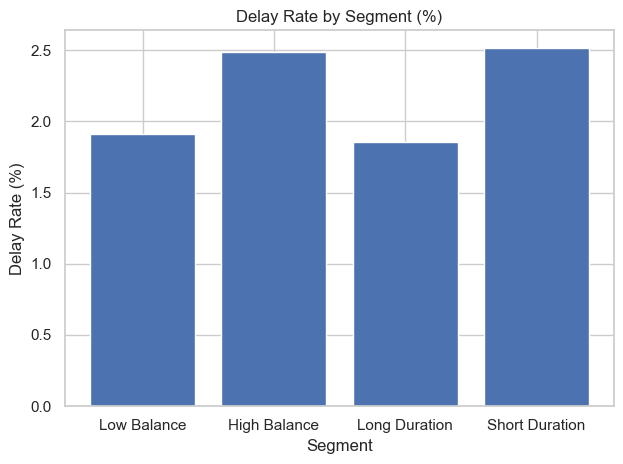

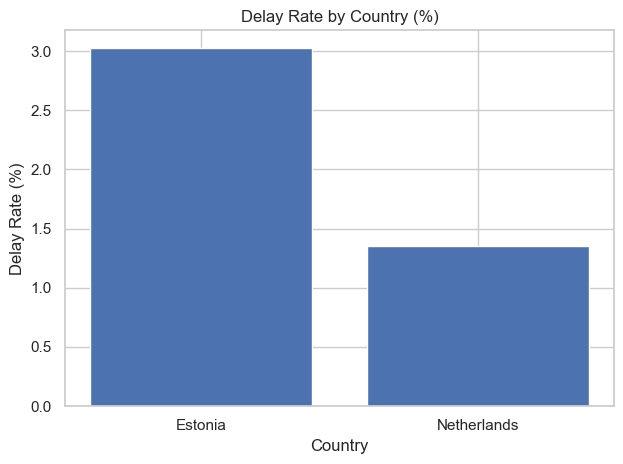

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
# df = pd.read_csv("/mnt/data/Analyst_case_study.csv")
df['report_date_local'] = pd.to_datetime(df['report_date_local'])
df['loan_issued_at'] = pd.to_datetime(df['loan_issued_at'])

# Define delay
df['in_delay'] = df['days_past_due'].fillna(0) > 0

# 1) High vs low balance
high_balance_threshold = df['outstanding_balance'].median()
df['high_balance'] = df['outstanding_balance'] > high_balance_threshold
delay_by_balance = df.groupby('high_balance')['in_delay'].mean().reset_index()
delay_by_balance['label'] = delay_by_balance['high_balance'].map({True: 'High Balance', False: 'Low Balance'})
delay_by_balance = delay_by_balance[['label', 'in_delay']]

# 2) Short vs long duration
short_duration_threshold = df['loan_duration'].median()
df['short_duration'] = df['loan_duration'] <= short_duration_threshold
on_time_by_duration = df.groupby('short_duration')['in_delay'].mean().reset_index()
on_time_by_duration['label'] = on_time_by_duration['short_duration'].map({True: 'Short Duration', False: 'Long Duration'})
on_time_by_duration = on_time_by_duration[['label', 'in_delay']]

# 3) Country delay rate
country_delay_rate = df.groupby('country')['in_delay'].mean().reset_index()
country_delay_rate = country_delay_rate.rename(columns={'country': 'label'})

# Combine tidy summary
summary = pd.concat([
    delay_by_balance.assign(metric='Balance Segment'),
    on_time_by_duration.assign(metric='Duration Segment'),
    country_delay_rate.assign(metric='Country')
], ignore_index=True)

# Save to CSV so you can download
# summary_path = "/mnt/data/delay_analysis_summary.csv"
# summary.to_csv(summary_path, index=False)

# Print a readable text summary
print("=== Delay Rate Summary ===")
for _, row in summary.iterrows():
    print(f"{row['metric']:>17} | {row['label']:<15} -> {row['in_delay']*100:.2f}%")

# ------------- Charts -------------
# Chart 1: Balance & Duration segments
fig1 = plt.figure()
seg_plot = pd.concat([delay_by_balance, on_time_by_duration], ignore_index=True)
plt.bar(seg_plot['label'], seg_plot['in_delay']*100)
plt.title("Delay Rate by Segment (%)")
plt.xlabel("Segment")
plt.ylabel("Delay Rate (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Chart 2: Country delay rates
fig2 = plt.figure()
plt.bar(country_delay_rate['label'], country_delay_rate['in_delay']*100)
plt.title("Delay Rate by Country (%)")
plt.xlabel("Country")
plt.ylabel("Delay Rate (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# summary_path


In [106]:
summary

,label,in_delay,metric
0,Low Balance,0.019110,Balance Segment
1,High Balance,0.024857,Balance Segment
2,Long Duration,0.018578,Duration Segment
3,Short Duration,0.025139,Duration Segment
4,Estonia,0.030234,Country
5,Netherlands,0.013556,Country


In [127]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Prepare daily totals
df = pd.read_csv("Analyst_case_study.csv")

df['report_date_local'] = pd.to_datetime(df['report_date_local'])
daily = df.groupby('report_date_local')['repaid_amount_day'].sum().reset_index()
daily = daily.set_index('report_date_local').asfreq('D', fill_value=0)

# Train-test split
train = daily.iloc[:-30]
test = daily.iloc[-30:]

# Fit SARIMAX model
model = SARIMAX(train['repaid_amount_day'],
                order=(1,1,1),
                seasonal_order=(1,1,1,7))
results = model.fit()

# Forecast 7 days ahead
forecast = results.get_forecast(steps=7)
pred_df = forecast.summary_frame()

print(pred_df[['mean', 'mean_ci_lower', 'mean_ci_upper']])


pred_df


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43515D+00    |proj g|=  9.90178D-02

At iterate    5    f=  9.38034D+00    |proj g|=  3.37213D-02

At iterate   10    f=  9.37246D+00    |proj g|=  4.40322D-04

At iterate   15    f=  9.37243D+00    |proj g|=  7.28077D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   2.184D-05   9.372D+00
  F =   9.3724251687209055     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
repaid_a

/Users/farizrzayev/Desktop/projects/DaxTutorials/Dax/.venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/farizrzayev/Desktop/projects/DaxTutorials/Dax/.venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/farizrzayev/Desktop/projects/DaxTutorials/Dax/.venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:3220: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
 This problem is unconstrained.


repaid_amount_day,mean,mean_se,mean_ci_lower,mean_ci_upper
2025-06-09,69630.852766,11027.189232,48017.959020,91243.746512
2025-06-10,16615.810380,11079.174724,-5098.973058,38330.593818
2025-06-11,11375.194967,11083.951246,-10348.950283,33099.340216
2025-06-12,10232.802635,11087.159915,-11497.631490,31963.236759
2025-06-13,11057.805697,11090.263134,-10678.710625,32794.322019
2025-06-14,3760.736380,11093.357897,-17981.845565,25503.318326
2025-06-15,3202.621980,11096.451261,-18546.022849,24951.266808


In [133]:
per_loan.to_csv("loan_metrics.csv")